## PROTO V1.0
<div class='alert alert-success'>
Ce petit notebook permet d'évaluer Abstract Torch sur un petit réseau. 
Pour cela, on créé AbstractNN, un petit réseau composé de 3 couches de convolution suivies de ReLU, puis de deux couches FC suivies également de ReLU. 
Pour l'entrainement uniquement, un softmax est appliqué en sortie de réseau
</div>

Dans la classe AbstractNN, la méthode forward de nn.Linear est surchargée de façon standard.
C'est à dire que si l'on instancie model=AbstractNN(), model(x) applique forward à x comme dans n'importe quel réseau. 

AbstractNN possède une méthode abstract_forward() qui fait appelle à AbstractLinear et AbstractReLU. 
<div class='alert alert-info'>
Le lecteur avisé notera que 
    model(x)=nn.softmax(model.abstract_forward(x_abstract)[0])
</div>



In [40]:


%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn

from abstractModule import AbstractLinear as AL
from abstractModule import AbstractReLU as AR

from util.train import Train as T
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch import optim
import os




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Ici on importe le dataset CIFAR0, normalisation et random split pour l'entrainement

In [41]:

path ='dataset'

os.makedirs(path, exist_ok=True)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.4914, 0.4822, 0.4465], std =[0.247, 0.243, 0.261]),
        #transforms.Resize((56,56))
    ])



dataset_train = datasets.CIFAR10(root = path,transform = transform, download = True, train = True)
dataset_test =datasets.CIFAR10( root =path,transform=transform ,download = True, train = False)
val =0.2
len_data_train = len(dataset_train)
train_size =int((1-val)*len_data_train)

val_size = int(val*len_data_train)

train_dataset, val_dataset = random_split(dataset_train, [train_size,val_size])


Files already downloaded and verified
Files already downloaded and verified


Ici on génère notre classe AbstractNN et sa fameuse méthode abstrac_forward


In [47]:


class AbstractNN(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("cpu")):

        super(AbstractNN,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,32,3,device=self.device)
        self.conv3=nn.Conv2d(32,32,3,device=self.device)

       

        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(21632,64,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(64,10,device=self.device))
        self.softMax =nn.Softmax()
    def forward(self,x):
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.conv2(x)
        x=torch.relu(x)
        x=self.conv3(x)
        x=torch.relu(x)
    
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x= self.softMax(x)
        return x
    
    def abstract_forward(self,x,add_symbol=False,device=torch.device("cpu")):
        self.device=device
        
        x_true = x
        x_true = x_true[0].unsqueeze(0)

        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
     
       
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
       


        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv3,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
       
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
      
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
       
        
        return x,x_min,x_max,x_true
        

Un petit script pour l'entrainement, disons 40 EPOCH

In [21]:
model =AbstractNN(num_depth=3)

num_epochs =40
learning_rate=0.01
batch_size = 128
device = torch.device("cpu")
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.99))
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.98)
criterion = nn.CrossEntropyLoss()
TD= T(model=model,
            device=device
                            )
model = TD.train_model(train_dataset,val_dataset,
                        criterion=criterion,  
                        batch_size= batch_size,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        num_epochs=num_epochs,
                        learning_rate=learning_rate,
                        resname='SimpleCNN',verbose=False)

----------------------------------------------------------------------------------------------------
Epoch 0/40
----------------------------------------------------------------------------------------------------
EPOCH ACCURACY = 25.78 %
****************************************************************************************************
train Loss: 1.9822 Acc: 25.7812
****************************************************************************************************
EPOCH ACCURACY = 40.30 %
****************************************************************************************************
val Loss: 1.9784 Acc: 40.3045
****************************************************************************************************

----------------------------------------------------------------------------------------------------
Epoch 1/40
----------------------------------------------------------------------------------------------------
EPOCH ACCURACY = 46.09 %
********************************

In [48]:
model=AbstractNN(num_depth=3    )
model.load_state_dict(torch.load('dataset/SimpleCNN_19_valacc_63.04086685180664.pth'))

<All keys matched successfully>

Label:6


torch.Size([3, 32, 32])

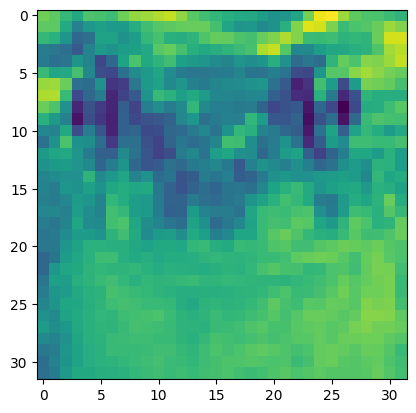

In [69]:
import matplotlib.pyplot as plt
import numpy as np

img, label = dataset_train[151]
plt.imshow(img[0])
print(f"Label:{label}")
img.shape

In [70]:
max= torch.max(img)
min = torch.min(img)
scale = max-min
print(scale)

from abstract import abstractTensor as AT

x=AT(img,alpha =0.001*scale*torch.ones(32*32*3))
x=x.abstract_tensor()
x.shape

tensor(3.7216)
torch.Size([3, 32, 32])


torch.Size([3074, 3, 32, 32])

In [79]:
with torch.no_grad():
   result_1= model(x[0].unsqueeze(0))
 
   result,x_min,x_max,x_true=model.abstract_forward(x,add_symbol=False)

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")


x.shape=torch.Size([3074, 3, 32, 32])
x.shape=torch.Size([3074, 16, 30, 30])
x.shape=torch.Size([3074, 32, 28, 28])
torch.FloatTensor
torch.FloatTensor
y_min       =  tensor([ -0.0000,  -6.8177,  -0.7678,   6.4448,  -5.6482,  -7.2621,  -9.4171,
         -9.6199, -12.7473,  -0.0000])
y_max       =  tensor([ 0.0000,  9.1135, 22.5911, 22.9443, 15.4084, 21.8201, 15.4785, 19.6211,
        16.3603,  0.0000])
center Ztp  =  tensor([-0.0000,  1.1479, 10.9116, 14.6946,  4.8801,  7.2790,  3.0307,  5.0006,
         1.8065, -0.0000])
y_true      =  tensor([[ 0.0000,  0.0000, 10.8098, 14.7275,  4.2332,  6.5975,  0.6712,  3.3624,
          0.0000,  0.0000]])
y_max-x_min =  tensor([ 0.0000, 15.9311, 23.3589, 16.4995, 21.0566, 29.0822, 24.8956, 29.2410,
        29.1076,  0.0000])
Trash symbol=  tensor([ 0.0000,  7.5439,  9.7697,  6.9235,  9.2894, 12.8498, 11.5539, 13.4164,
        13.7587,  0.0000])


Voici le premier affichage de relevance calculé par AbstractTorch

tensor(3)
torch.Size([1024])


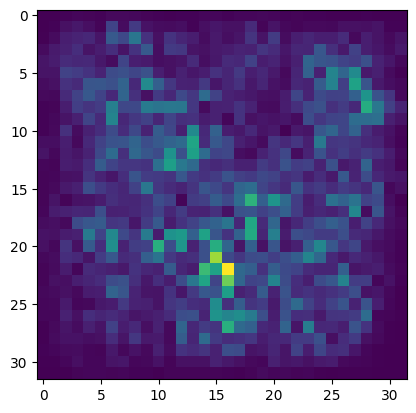

In [77]:
value=torch.argmax(result[0])
print(value)
concat= torch.abs(result[1:1025,value])+torch.abs(result[1025:2049,value])+torch.abs(result[2049:3073,value])
print(concat.size())

concat = concat.reshape(32,32)
plt.imshow(torch.abs(concat.cpu()).numpy(), cmap='viridis')